# Logistic Regression

We would like to perform hyperparameter selection over the set of all logistic regression models.

Logistic regression with $K > 2$ classes is actually broken into two "flavours":
- **one-versus-all**: Fit a separate binary classifier for each class against the rest, and classify according to the highest score.
- **multinomial**: Fit a single classifier with $K$ outputs (one of them is 1), and take the softmax thereof. This is the flavour we learn in STAT 441, and is the default used by `sklearn`.

We choose to focus on multinomial logistic regression here.

For regularization, ElasticNet encompasses both L1 and L2 penalties (and with a weak enough regularization term, no-penalty as well).
We thus parameterize the search space by the ratio of the L1 and L2 penalties, and the coefficient C representing the extent of regularization.

Unfortunately, the only solver in `sklearn` that works with ElasticNet is the `saga` solver, and that solver is quite sluggish.

## Setup

In [1]:
from tune import outer_cv, LogisticRegressionBayesTuner, LogisticRegressionGridTuner, Real

Using 5 cores


## Grid Search

The nested cross-validation process trains `n_outer * ((n_steps * n_inner) + 1)` models.

On a single thread, with `n_outer = n_inner = 5` and `n_steps = steps_C * steps_l1_ratio = 3 * 3 = 9`, the nested CV process takes about half an hour, or about 9 seconds per model.
9 seconds per model is very fast, but if we were to increase the search space to something more dense; say, `steps_C = steps_l1_ratio = 10`), then we would be looking at multiple hours of execution.

Outer CV using 5 cores


[INFO/ForkPoolWorker-11] child process calling self.run()
[INFO/ForkPoolWorker-12] child process calling self.run()
[INFO/ForkPoolWorker-13] child process calling self.run()
[INFO/ForkPoolWorker-14] child process calling self.run()
[INFO/ForkPoolWorker-15] child process calling self.run()
[INFO/ForkPoolWorker-11] 1  Cached result loaded from ../models/logistic_regression_grid/cv-1.mdl
[INFO/ForkPoolWorker-13] 3  Cached result loaded from ../models/logistic_regression_grid/cv-3.mdl
[INFO/ForkPoolWorker-12] 2  Cached result loaded from ../models/logistic_regression_grid/cv-2.mdl
[INFO/ForkPoolWorker-14] 4  Cached result loaded from ../models/logistic_regression_grid/cv-4.mdl
[INFO/ForkPoolWorker-15] 5  Cached result loaded from ../models/logistic_regression_grid/cv-5.mdl
[INFO/ForkPoolWorker-13] 3  Best configuration: {'C': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000.]),

<Figure size 1000x1000 with 0 Axes>

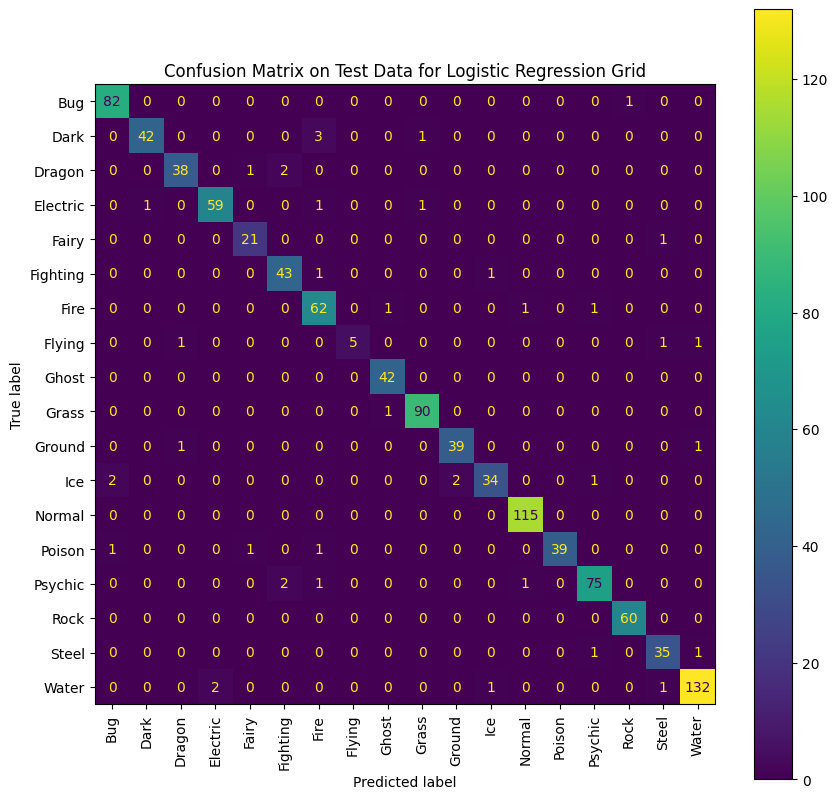

0.9611103588354772

In [4]:
grid_tuner = LogisticRegressionGridTuner(steps_C=3, steps_l1_ratio=3)
space = dict(
    C=Real(low=1e-4, high=1e4, prior="log-uniform"),
    l1_ratio=Real(low=0.0, high=1.0, prior="uniform"),
)
outer_cv(tuner=grid_tuner, search=space, name="Logistic Regression Grid")

## Bayesian Optimization

Another way to improve our density where it matters is to use Bayesian Optimization to sample over the entire continuous space.

Outer CV using 5 cores


[INFO/ForkPoolWorker-6] child process calling self.run()
[INFO/ForkPoolWorker-7] child process calling self.run()
[INFO/ForkPoolWorker-8] child process calling self.run()
[INFO/ForkPoolWorker-9] child process calling self.run()
[INFO/ForkPoolWorker-10] child process calling self.run()
/home/xujustinj/projects/pokemon-type-classification/.venv/lib/python3.10/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/xujustinj/projects/pokemon-type-classification/.venv/lib/python3.10/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/xujustinj/projects/pokemon-type-classification/.venv/lib/python3.10/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot

<Figure size 1000x1000 with 0 Axes>

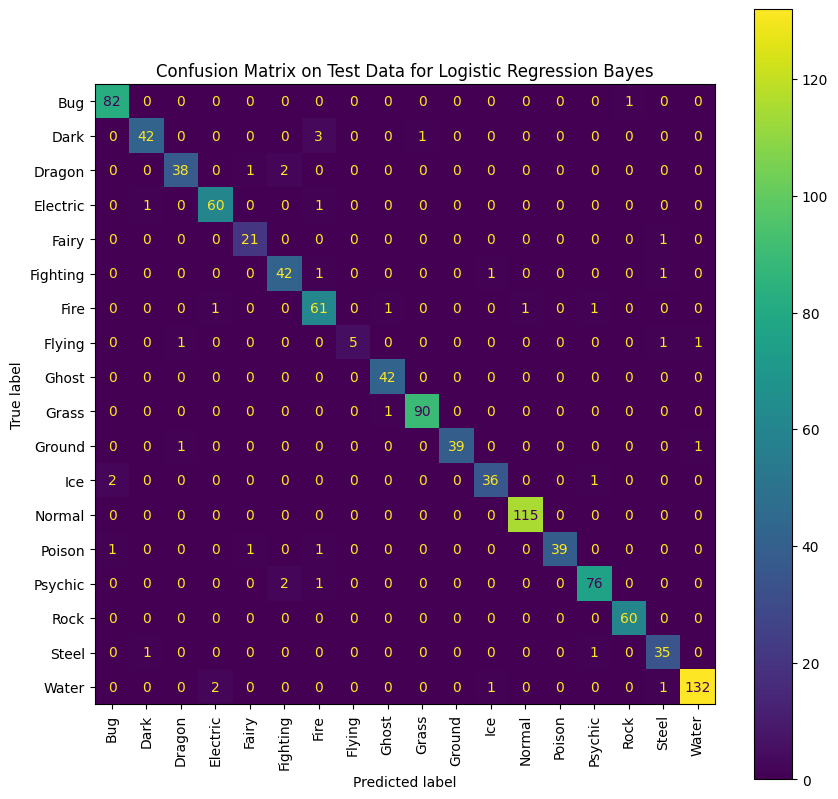

0.9630151207402392

In [3]:
bayes_tuner = LogisticRegressionBayesTuner()
space = dict(
    C=Real(low=1e-4, high=1e4, prior="log-uniform"),
    l1_ratio=Real(low=0.0, high=1.0, prior="uniform"),
)
outer_cv(tuner=bayes_tuner, search=space, name="Logistic Regression Bayes")

## LASSO

Through the above process we see that the optimal regularization is always just L1 (LASSO).
Thus, we can save ourselves some trouble by reducing our search space to LASSO only.